#Detecting Freezing of Gait Episodes in Parkinson's disease: A Comprehensive Step-by-Step Approach:

Objective: the development of a model to predict Parkinson's freezing-of-gait episodes

##1. Introduction
Freezing of gait (FOG) is a debilitating symptom that affects individuals diagnosed with Parkinson’s disease, which significantly impacting their ability to walk and limiting their mobility and independence. Machine learning (ML) techniques can provide valuable insights into the occurrence and causes of FOG episodes. By leveraging ML, medical professionals can enhance their evaluation, monitoring, and prevention of FOG events. This notebook is based on Parkinson's Freezing of Gait Prediction competition dataset which includes data collected from a wearable 3D lower back sensor. The goal of this project is detecting the start and stop of each freezing episode, as well as identifying three types of FOG events: Start Hesitation, Turn, and Walking. bold text

##2. The Big Picture
The objective is to develop a model to detect and predict Parkinson's FOG episodes. These episodes will be predicted based on time series data that was recorded for each patient during the execution of a specific protocol in addition to some provided patient characteristics. Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Start Hesitation, Turn, and Walking), the problem is a one-class classification. The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly. Considering these requirements, this notebook presents a LightGBM (Light Gradient Boosting Model) model developed specifically to optimize the desired evaluation metric.

##3.Data Collection
Each patient in the dataset is considered as a subject. The dataset includes two types of experiments conducted to assess conditions of the patient: 1. TDCSFOG dataset: This dataset consists of data series collected in a lab, where subjects completed a FOG-provoking protocol. 2. DeFOG dataset: This dataset comprises data series collected in the subject's home, where the subject also completed a FOG-provoking protocol. The identification of each series in the TDCSFOG dataset is provided in the "tdcsfog_metadata.csv" file. Each series is uniquely identified by the Subject, Visit, Test, and Medication condition. Similarly, the identification of each series in the DeFOG dataset is given in the "defog_metadata.csv" file, supplied by unique identifiers for Subject, Visit, and Medication condition

In [1]:
'''
Connecting Google Drive
'''
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
'''
install catboost module
'''
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [3]:
'''
Load modules
'''
import pandas as pd
import glob
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import os
import warnings
import pickle
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
'''
Unziping data folder

'''
!unzip gdrive/My\ Drive/defog.zip > /dev/null

In [5]:
'''
Creating home dataset after merging all csv file
'''
csv_folder = '/content/defog'  # Update this with the path to your CSV files
df=pd.DataFrame()
for csv_file in os.listdir(csv_folder):
    if csv_file.endswith('.csv'):
        csv_path = os.path.join(csv_folder, csv_file)
        temp_df = pd.read_csv(csv_path)
        df = df.append(temp_df, ignore_index=True)

##4. Data Exploration
We first look at the subjects dataset.

In [ ]:
'''
Displaying shape of data
'''
df.shape

(13525702, 9)

In [ ]:
'''
Displaying content of data
'''
df

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-0.989968,-0.096900,-0.032962,0,0,0,False,False
1,1,-0.990478,-0.098616,-0.035393,0,0,0,False,False
2,2,-0.989018,-0.098869,-0.034183,0,0,0,False,False
3,3,-0.992178,-0.099121,-0.034910,0,0,0,False,False
4,4,-0.991226,-0.098661,-0.034451,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
13525697,300283,-0.929958,-0.158213,-0.334716,0,0,0,False,False
13525698,300284,-0.934397,-0.159220,-0.333716,0,0,0,False,False
13525699,300285,-0.936518,-0.162630,-0.332749,0,0,0,False,False
13525700,300286,-0.931836,-0.163615,-0.332280,0,0,0,False,False


In [ ]:
'''
Checking Unique class in target attribute
'''
df.Turn.value_counts()

0    12938216
1      587486
Name: Turn, dtype: int64

##5. Data Preprocessing

In [6]:
def preprocessing_inputs(df):
  df = df.copy()
  # remove unneed col
  unneed_col = ['Time', 'StartHesitation', 'Walking','Valid','Task']
  df = df.drop(unneed_col,axis = 1)
   #split Data X,y
  X = df.drop("Turn",axis = 1)
  y = df['Turn']
  # Train test split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
  return X_train,X_test,y_train,y_test

In [7]:
X_train,X_test,y_train,y_test= preprocessing_inputs(df)

Balancing Unbalanced home data

In [8]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [9]:
oversampler = SMOTE(random_state=1)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

In [ ]:
y_train_smote.value_counts()

0    9056271
1    9056271
Name: Turn, dtype: int64

In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(
    y_train_smote.value_counts(),
    # values='Pass/Fail',
    names=["PASS", "FAIL"],
    title="Class Distribution",
    width=500
)

fig.show()

##6. Model
Given the availability of labeled targets in the dataset, a supervised learning approach is suitable for addressing this problem. Since there are multiple targets (Fog occur or not while Turn), the problem is a binary-class classification. The evaluation metric in this project is the mean average precision, which measures the average precision of predictions for each event class. Thus, accurate predictions of correct event types are more important than predicting all events correctly

###6.1. Model Selection
For this project, after tuning different ML algorithms, LightGBM algorithm,XGB algorithm,CatBoost algorithm,DecisionTree alogrithm is taken into account for the following reasons.

The dataset is large including many features, so a highly-effiecient model is required.

The task involves Binary-class classification.

The Binary-class problem exhibits imbalanced classes.

It is crucial to capture complex and non-linear relationships in the data.

###6.2. Model Training

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test):
    # Calculate accuracy
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Generate a classification report
    clr = classification_report(y_test, y_pred)

    # Create and display a heatmap for the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    # plt.yticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("Classification Report:\n----------------------\n", clr)

# Example usage
# evaluate_model(model, X_test, y_test)


##7. Prediction and Submission
The defog models are evaluated based on their corresponding test data, and the resulting predictions are submitted to the competition.

Model 1

DecisionTree Classification

Accuracy: 86.46%


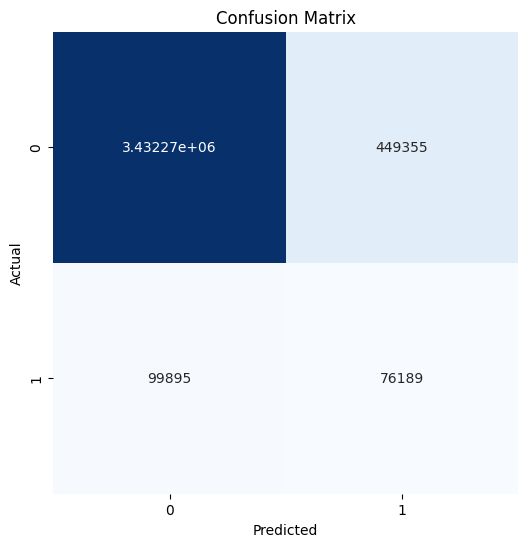

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      0.88      0.93   3881627
           1       0.14      0.43      0.22    176084

    accuracy                           0.86   4057711
   macro avg       0.56      0.66      0.57   4057711
weighted avg       0.94      0.86      0.90   4057711



In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train_smote, y_train_smote)
pickle.dump(model,open('DT.pkl','wb'))
evaluate_model(model, X_test, y_test)

Model 2

CatBoost Classification
---




Learning rate set to 0.5
0:	learn: 0.5833115	total: 3.6s	remaining: 59m 57s
1:	learn: 0.5406788	total: 6.97s	remaining: 57m 56s
2:	learn: 0.5256876	total: 12.4s	remaining: 1h 8m 50s
3:	learn: 0.5176912	total: 15.8s	remaining: 1h 5m 24s
4:	learn: 0.5136026	total: 19s	remaining: 1h 3m
5:	learn: 0.5093945	total: 22.3s	remaining: 1h 1m 33s
6:	learn: 0.5053938	total: 27.5s	remaining: 1h 5m 2s
7:	learn: 0.5013279	total: 31.1s	remaining: 1h 4m 21s
8:	learn: 0.4985840	total: 34.6s	remaining: 1h 3m 28s
9:	learn: 0.4964280	total: 38.2s	remaining: 1h 3m 2s
10:	learn: 0.4948529	total: 42.9s	remaining: 1h 4m 14s
11:	learn: 0.4912415	total: 46.1s	remaining: 1h 3m 16s
12:	learn: 0.4895489	total: 49.2s	remaining: 1h 2m 13s
13:	learn: 0.4869591	total: 53.2s	remaining: 1h 2m 24s
14:	learn: 0.4848475	total: 58.1s	remaining: 1h 3m 32s
15:	learn: 0.4832334	total: 1m 2s	remaining: 1h 4m
16:	learn: 0.4815000	total: 1m 8s	remaining: 1h 5m 40s
17:	learn: 0.4795485	total: 1m 13s	remaining: 1h 7m 8s
18:	learn: 0

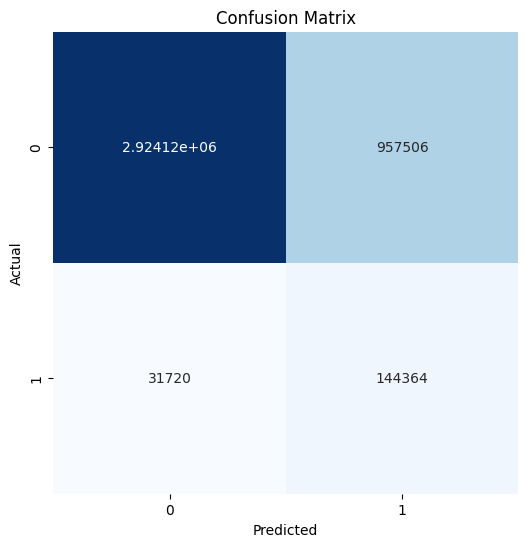

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.75      0.86   3881627
           1       0.13      0.82      0.23    176084

    accuracy                           0.76   4057711
   macro avg       0.56      0.79      0.54   4057711
weighted avg       0.95      0.76      0.83   4057711



In [ ]:
model = CatBoostClassifier()
model.fit(X_train_smote, y_train_smote)
pickle.dump(model,open('CatBoost.pkl','wb'))
evaluate_model(model, X_test, y_test)

Model 3

XGBoost Classification

Accuracy: 75.41%


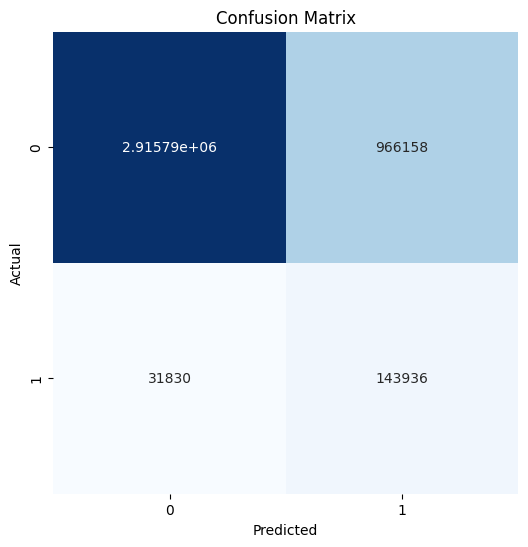

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.75      0.85   3881945
           1       0.13      0.82      0.22    175766

    accuracy                           0.75   4057711
   macro avg       0.56      0.79      0.54   4057711
weighted avg       0.95      0.75      0.83   4057711



In [12]:
model=XGBClassifier()
model.fit(X_train_smote, y_train_smote)
pickle.dump(model,open('XGB.pkl','wb'))
evaluate_model(model, X_test, y_test)

Model 4

Light GBM Classification

[LightGBM] [Info] Number of positive: 9056589, number of negative: 9056589
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.673934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18113178, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 74.90%


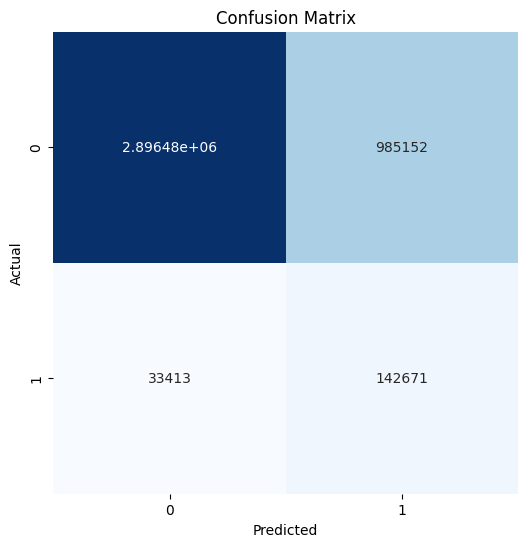

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.75      0.85   3881627
           1       0.13      0.81      0.22    176084

    accuracy                           0.75   4057711
   macro avg       0.56      0.78      0.53   4057711
weighted avg       0.95      0.75      0.82   4057711



In [ ]:
model=LGBMClassifier()
model.fit(X_train_smote, y_train_smote)
pickle.dump(model,open('LGBM.pkl','wb'))
evaluate_model(model, X_test, y_test)